In [35]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import pyslha
import ROOT

ROOT.gSystem.Load(os.path.abspath(os.path.join(os.getcwd(),"../Delphes/libDelphes.so")))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

# Load Model Parameters

In [2]:
parameters = pyslha.readSLHAFile('../DMSimp_monojet/Cards/param_card.dat')
mMed = parameters.blocks['MASS'][55]
mDM = parameters.blocks['MASS'][52]
gVq = parameters.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
gAq = parameters.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
gVx = parameters.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
gAx = parameters.blocks['DMINPUTS'][3] # Mediator-DM axial coupling

# Set Delphes output file

In [3]:
inputFiles = {'point1' : './test.root'}

# Define Cuts

In [4]:
# Cuts 
## jets
pTj1min = 100.
pTjmin = 25.
etamax = 2.4
## MET
minMET = 250.
## Electrons
pTmin_el = 10.
etamax_el = 2.5
nMax_el = 0
## Muons
pTmin_mu = 10.
etamax_mu = 2.4
nMax_mu = 0


# Load events, apply cuts and store relevant info

In [26]:
pTj1 = []
weights = []
met = []
genmet = []
dmPT = []
njets = []
totalweight = 0.0
cutFlow = OrderedDict({'Electron Veto' : 0, 'Muon Veto' : 0, 'pTmiss cut': 0, 'pT(j1) cut' : 0})
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        

        particles = tree.Particle
        jets = tree.Jet
        weight = tree.Event.At(0).Weight
        totalweight += weight

        genmissingET = tree.GenMissingET.At(0) 
        missingET = tree.MissingET.At(0)
        electrons = tree.Electron
        muons = tree.Electron
        
        # Get DM particles (gen level)
        dmList = []
        for ip in range(particles.GetEntries()):
            p = particles.At(ip)
            if abs(p.PID) != 52:
                continue
            if p.Status != 1:
                continue
            dmList.append(p)

        
        # Filter electrons:
        electronList = []
        for iel in range(electrons.GetEntries()):
            electron = electrons.At(iel)
            if electron.PT < pTmin_el:
                continue
            if abs(electron.Eta) > etamax_el:
                continue
            electronList.append(electron)
        
        # Filter muons:
        muonList = []
        for imu in range(muons.GetEntries()):
            muon = muon.At(imu)
            if muon.PT < pTmin_mu:
                continue
            if abs(muon.Eta) > etamax_mu:
                continue
            muonList.append(muon)
            
        # Filter jets
        jetList = []
        for ijet in range(jets.GetEntries()):
            jet = jets.At(ijet)
            if jet.PT < pTjmin:
                continue
            if abs(jet.Eta) > etamax:
                continue
            jetList.append(jet)  
        jetList = sorted(jetList, key = lambda j: j.PT, reverse=True)    
        
        njets.append(jets.GetEntries())

        # Apply cuts:
        ## Veto electrons
        if len(electronList) > nMax_el: continue  
        cutFlow['Electron Veto'] += weight
        ## Veto muons
        if len(muonList) > nMax_mu: continue  
        cutFlow['Muon Veto'] += weight
        ## Cut on MET
        if genmissingET.MET < minMET: continue  
        cutFlow['pTmiss cut'] += weight
        ## Veto zero jet events
        if len(jetList) < 1 or jetList[0].PT < pTj1min: continue
        cutFlow['pT(j1) cut'] += weight
        
        if len(dmList) !=2 :
            print('Could not find 2 DM particles in the event')
            print(len(dmList))
            for dm in dmList:
                print(dm.PID,dm.PT)
            break
        
        # Store relevant data
        dmPT.append(np.sqrt((dmList[0].Px + dmList[1].Px)**2 + (dmList[0].Py + dmList[1].Py)**2))
        pTj1.append(jetList[0].PT)
        weights.append(weight)
        met.append(missingET.MET)
        genmet.append(genmissingET.MET)
f.Close()

weights = np.array(weights)
pTj1 = np.array(pTj1)
met = np.array(met)
genmet = np.array(genmet)
njets = np.array(njets)

## Print cutflow

In [32]:
# Print cutflow:
print('totalweight = %1.3f' %totalweight)
for cut,weight in cutFlow.items():
    print(cut,'eff = %1.3f' %(weight/totalweight))

totalweight = 157.892
Electron Veto eff = 1.000
Muon Veto eff = 1.000
pTmiss cut eff = 0.172
pT(j1) cut eff = 0.170


## Plot Results

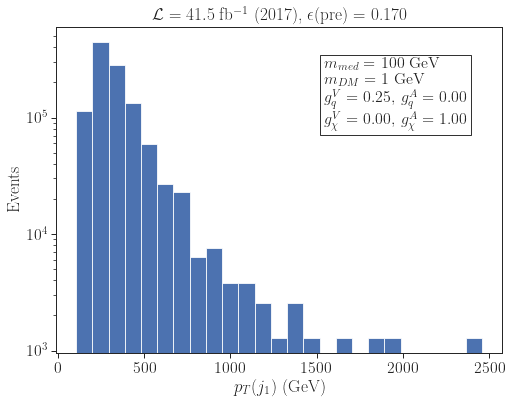

In [31]:
lum2017 = 41.5 #fb^-1
fig = plt.figure(figsize=(8,6))
plt.hist(pTj1,bins=25,weights=weights*1e3*lum2017)
plt.title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f' 
          %(lum2017,list(cutFlow.values())[-1]/totalweight))
plt.xlabel(r'$p_{T}(j_{1})$ (GeV)')
plt.ylabel('Events')
plt.yscale('log')
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.6,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.show()

# Get official CMS data

In [36]:
pickleFile = '../monoJet/CMS-EXO-20-004-data/Signaltemplates_DMsimp_spin-1_Monojet_DF.pcl'
df = pd.read_pickle(pickleFile)

### Filter model

In [92]:
if gAx:
    dfModel = df[(df["$m_{med}$"] == mMed) & (df["$m_{DM}$"] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df["Coupling"] == "Axial")]
elif gVx:
    dfModel = df[(df["$m_{med}$"] == mMed) & (df["$m_{DM}$"] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df["Coupling"] == "Vector")]

if len(dfModel) != 1:
    print('%i data rows selected' %(len(dfModel)))

In [93]:
bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if "bin_" in c}
cmsData = {c : dfModel[c].iloc[0] for c in bins}
rightBin = 2000.
binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()

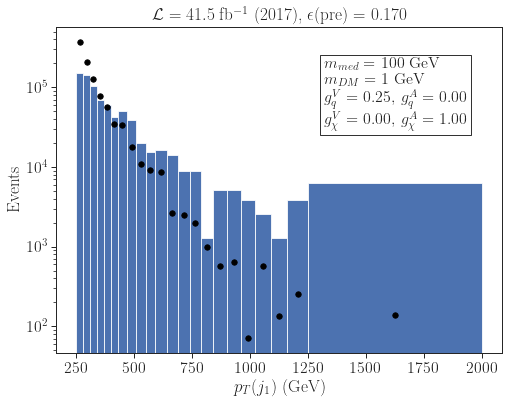

In [96]:
lum2017 = 41.5 #fb^-1
fig = plt.figure(figsize=(8,6))
plt.hist(pTj1,bins=list(bins.values())+[rightBin],weights=weights*1e3*lum2017)
plt.scatter(x=binCenter,y=list(cmsData.values()),s=30,c='black')
plt.title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f' 
          %(lum2017,list(cutFlow.values())[-1]/totalweight))
plt.xlabel(r'$p_{T}(j_{1})$ (GeV)')
plt.ylabel('Events')
plt.yscale('log')
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.6,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.show()